# Tarea 1 - Redes densas
## Eduardo García Alarcón

### 3. Red densa conl PyTorch

A partir de la libreta https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2025-1/notebooks/1c_redes_densas_pytorch.ipynb, evalúa tres distintas configuraciones de redes densas que incluyan lo siguiente:

  - Más capas ocultas
  - Distintas funciones de activasión de las capas ocultas
  - Técnicas de regularización
  - Capas de normalizaciónl   

In [34]:
import numpy as np
import matplotlib.pyplot as plt

import torch as th
from torch import nn

# fijamos las semillas de los PRNG por reproducibilidad
np.random.seed(42)
th.manual_seed(42)

T_LOTE = 8

In [35]:
from sklearn.datasets import load_diabetes

db = load_diabetes(return_X_y=False, as_frame=True)
     

In [36]:
print(db.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [37]:
db['data']

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


/home/qweryedu/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


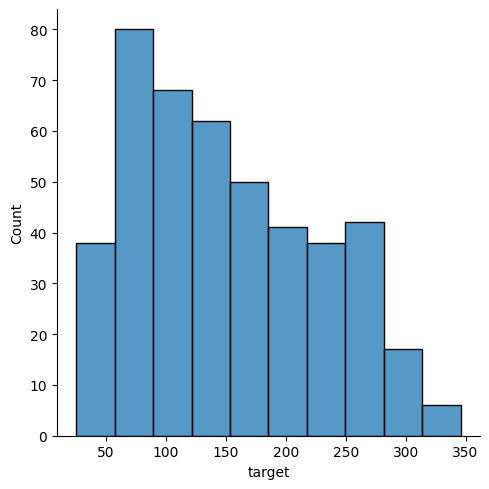

In [38]:
import pandas as pd
import seaborn as sns

sns.displot(db['target'][:])
plt.show()

In [39]:
from sklearn.model_selection import train_test_split

X_ent, X_prueba, y_ent, y_prueba = train_test_split(db['data'].to_numpy(),
                                                    db['target'].to_numpy(),
                                                    test_size = 0.3,
                                                    shuffle=True,
                                                    random_state=42)
X_ent, X_val, y_ent, y_val = train_test_split(X_ent,
                                              y_ent,
                                              test_size = 0.2,
                                              shuffle=True,
                                              random_state=42)

In [40]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_ent)

X_ent = sc.transform(X_ent)
X_val = sc.transform(X_val)
X_prueba = sc.transform(X_prueba)

Convertimos de NumPy a Tensor

Checamos por disponibilidad de GPU

In [41]:
disp = 'cuda:0' if th.cuda.is_available() else 'cpu'

X_ent = th.tensor(X_ent, dtype = th.float32, device = disp)
X_val = th.tensor(X_val, dtype = th.float32, device = disp)
X_prueba = th.tensor(X_prueba, dtype = th.float32, device = disp)

y_ent = th.tensor(y_ent,  dtype = th.float32, device = disp)
y_val = th.tensor(y_val,  dtype = th.float32, device = disp)
y_prueba = th.tensor(y_prueba, dtype = th.float32,  device = disp)

print(f'Forma de X_ent = {X_ent.shape}, y_ent = {y_ent.shape}')
print(f'Forma de X_val = {X_val.shape}, y_val = {y_val.shape}')
print(f'Forma de X_prueba = {X_prueba.shape}, y_prueba = {y_prueba.shape}')

Forma de X_ent = torch.Size([247, 10]), y_ent = torch.Size([247])
Forma de X_val = torch.Size([62, 10]), y_val = torch.Size([62])
Forma de X_prueba = torch.Size([133, 10]), y_prueba = torch.Size([133])


Nos aseguramos de las formas de los tensores de las predicciones

In [42]:
y_ent = y_ent.reshape((y_ent.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))
y_prueba = y_prueba.reshape((y_prueba.shape[0], 1))
print(f'Forma de y_ent = {y_ent.shape}, y_val = {y_val.shape} y_prueba = {y_prueba.shape}')

Forma de y_ent = torch.Size([247, 1]), y_val = torch.Size([62, 1]) y_prueba = torch.Size([133, 1])


Cargador de datos

In [43]:
from torch.utils.data import TensorDataset, DataLoader

entdl = DataLoader(TensorDataset(X_ent, y_ent),
                   batch_size=T_LOTE,
                   shuffle=True,
                   drop_last=True)
valdl = DataLoader(TensorDataset(X_val, y_val),
                   batch_size=T_LOTE,
                   shuffle=False,
                   drop_last=False)
pruebadl = DataLoader(TensorDataset(X_prueba, y_prueba),
                      batch_size=1,
                      shuffle=False,
                      drop_last=False)

## Module de nn

In [44]:
clin = nn.Linear(in_features = X_ent.shape[-1], # dimensión de entradas
                 out_features = 1, # número de neuronas (dimensión de salidas)
                 bias = True) # si usar sesgo o no
     

In [45]:
clin.to(disp)

Linear(in_features=10, out_features=1, bias=True)

In [46]:
clin(X_ent).shape

torch.Size([247, 1])

In [47]:
class MiLinear(nn.Module):
  # En el constructor recibimos la dimensión de las entradas y la de las salidas
  # e instanciamos la matriz de pesos W y el vector de sesgos b inicializándolos
  # con números aleatorios y ceros, respectivamente.
  def __init__(self, d_ent, d_sal):
    super(MiLinear, self).__init__()
    self.d_ent = d_ent
    self.d_sal = d_sal
    self.W = nn.Parameter(th.normal(size = (d_sal, d_ent), mean = 0, std = 0.1))
    self.b = nn.Parameter(th.zeros(d_sal, dtype = th.float32))

  # En este método se define el comportamiento del operador paréntesis. Al ser
  # una capa densa, se espera recibir una matriz x de n x d_ent y se realizaría
  # la operación de multiplicación de esta con la transpuesta de la matriz de
  # pesos de d_sal x d_ent y se sumaría el vector de sesgos de d_sal elementos
  def forward(self, x):
    return x @ self.W.T + self.b

In [48]:
milin = MiLinear(X_ent.shape[-1], 1)
milin.to(disp)

print(f'Instancia de {milin} con forma = {milin(X_ent).shape}')

Instancia de MiLinear() con forma = torch.Size([247, 1])


### Clase y funciones para optimizadores

In [49]:
from torch.optim import SGD

def paso_ent(modelo, fp, opt, X, y):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                  # a actualizaren en cero
  y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
  perdida = fp(y_hat, y) # se calcula la pérdida
  perdida.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo

  with th.no_grad():
    perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
  return perdida_paso

In [50]:
def entrena(modelo, fp, metrica, opt, entdl, valdl, n_epocas = 100):
  hist = {'perdida_ent': np.zeros(n_epocas, dtype = np.float32),
          'perdida_val': np.zeros(n_epocas, dtype = np.float32)}
  for e in range(n_epocas):
    # bucle de entrenamiento
    modelo.train()
    for lote, (Xlote, ylote) in enumerate(entdl):
      hist['perdida_ent'][e] += paso_ent(modelo, fp, opt, Xlote, ylote)

    # bucle de evaluación
    modelo.eval()
    for (Xlote, ylote) in valdl:
      with th.no_grad():
        y_pred = modelo(Xlote)
        hist['perdida_val'][e] += metrica(y_pred, ylote).cpu().numpy()

  return hist

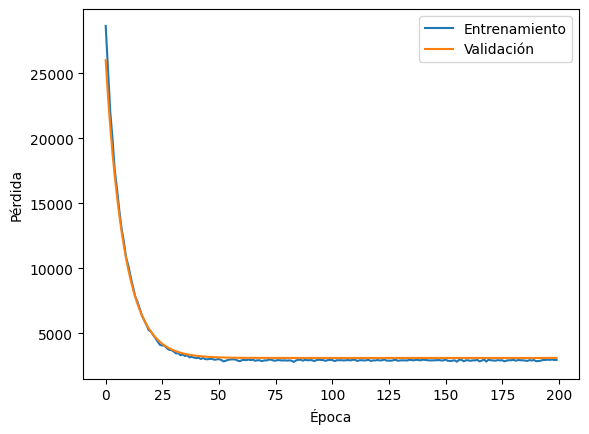

In [51]:
milin = nn.Linear(X_ent.shape[-1], 1)
milin.to(disp)

ecm = nn.MSELoss()
opt = SGD(milin.parameters(), lr = 1e-3)
hist = entrena(milin, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=200)

plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [52]:
class MiSGD(th.optim.Optimizer):
  def __init__(self, params, lr=1e-3):
    super(MiSGD, self).__init__(params, defaults = {'lr':lr})

  def step(self):
    for g in self.param_groups:
      for p in g['params']:
        p.data.subtract_(self.defaults['lr'] * p.grad)

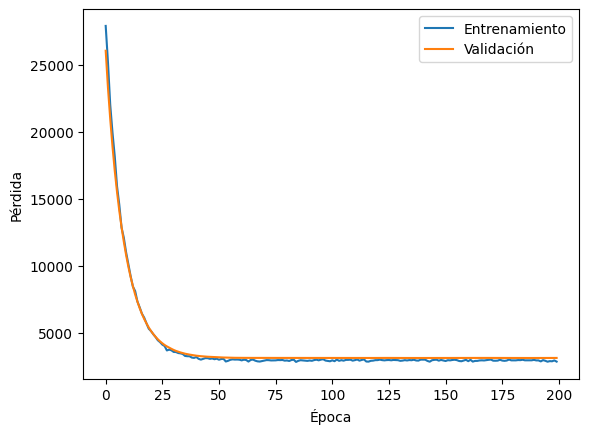

In [53]:
milin = MiLinear(X_ent.shape[-1], 1)
milin.to(disp)
ecm = nn.MSELoss()
opt = MiSGD(milin.parameters(), lr = 1e-3)
hist = entrena(milin, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=200)

plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
     

### Contenedor Sequential

In [54]:
modelo = nn.Sequential(nn.Linear(X_ent.shape[-1], 10),
                       nn.Sigmoid(),
                       nn.Linear(10,20),
                       nn.Sigmoid(),
                       nn.Linear(20, 1))

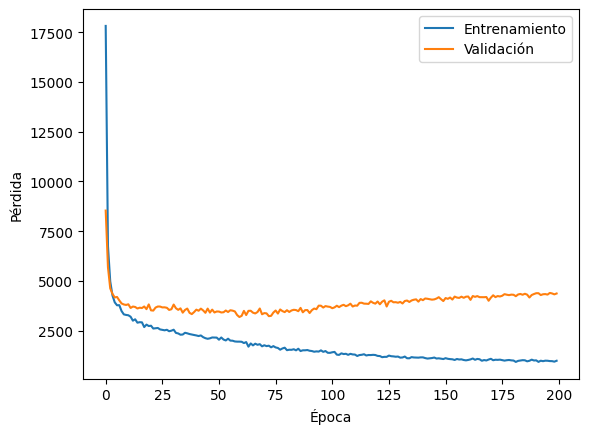

In [55]:
modelo.to(disp)
ecm = nn.MSELoss()
opt = SGD(modelo.parameters(), lr = 1e-3)
hist = entrena(modelo, ecm, nn.functional.mse_loss, opt,
               entdl, valdl, n_epocas=200)

plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [56]:
class MiMLP(nn.Module):
  def __init__(self, d_ent):
    super(MiMLP, self).__init__()
    self.c1 = nn.Linear(d_ent, 10)
    self.c2 = nn.Linear(10, 20)
    self.salida = nn.Linear(20, 1)

  def forward(self, x):
    x = nn.functional.sigmoid(self.c1(x))
    x = nn.functional.sigmoid(self.c2(x))
    return self.salida(x)

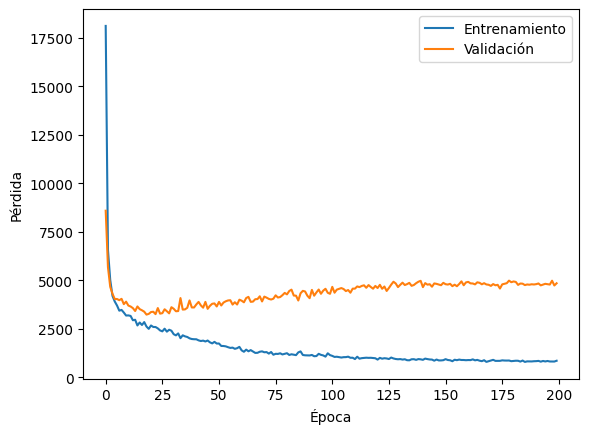

In [57]:
modelo = MiMLP(X_ent.shape[-1])
modelo.to(disp)

ecm = nn.MSELoss()
opt = SGD(modelo.parameters(), lr = 1e-3)
hist = entrena(modelo, ecm, nn.functional.mse_loss, opt,
               entdl, valdl, n_epocas=200)

plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [58]:
class MLPModList(nn.Module):
  def __init__(self, d_ent):
    super(MLPModList, self).__init__()
    self.cod = nn.ModuleList([nn.Linear(d_ent, 10), nn.Linear(10, 20)])
    self.salida = nn.Linear(20, 1)

  def forward(self, x):
    for c in self.cod:
      x = nn.functional.sigmoid(c(x))
    return self.salida(x)

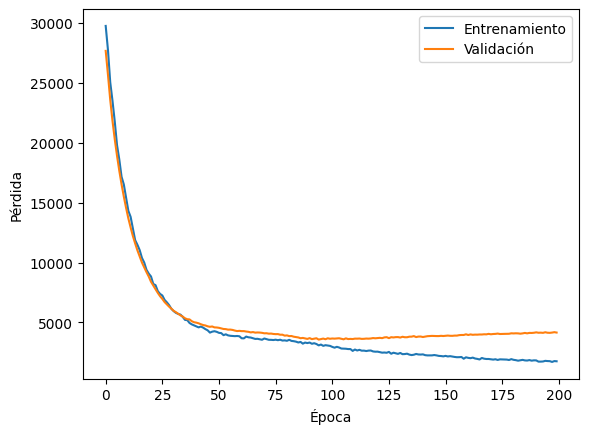

In [59]:
from torch.optim import AdamW

modelo = MLPModList(X_ent.shape[-1])
modelo.to(disp)

ecm = nn.MSELoss()
opt = AdamW(modelo.parameters(), lr = 1e-2)
hist = entrena(modelo, ecm, nn.functional.mse_loss, opt,
               entdl, valdl, n_epocas=200)

plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## Ahora si parte de la tarea

Por simpplicidad utilizaremos también el optimizador Adam que se importó arriba

### Red 1

In [65]:
class red1(nn.Module):
  def __init__(self, d_ent):
    # Se inicia el super constructor
    super(red1, self).__init__()
    self.cod = nn.ModuleList([nn.Linear(d_ent, 10), nn.Linear(10,20), nn.Linear(20,d_ent), nn.Linear(d_ent, 10), nn.Linear(10, 5)])
    self.salida = nn.Linear(5,1)

  # Definimos el forward
  def forward(self, x):
    for i, c in enumerate(self.cod):
      if i == 3:
        x = nn.functional.relu(c(x))
      else:
        x = nn.functional.sigmoid(c(x))
    return self.salida(x)

# Entrenamos el modelo
modelo = red1(X_ent.shape[-1])
modelo.to(disp)

#Perdida
ecm = nn.MSELoss()
#Optimizador
opt = AdamW(modelo.parameters(), lr=1e-2)
#Entrenamiento
hist = entrena(modelo, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=300)

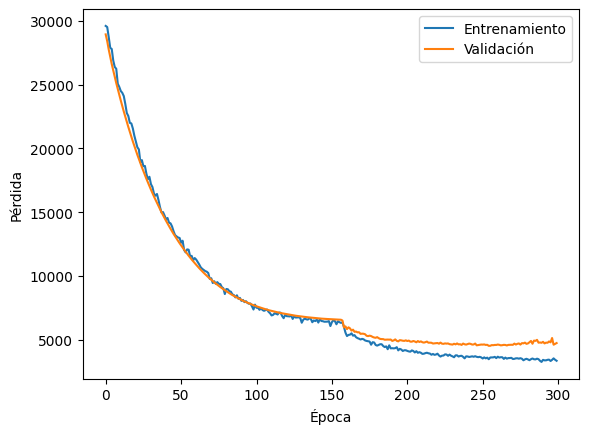

In [66]:
plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

### Red 2

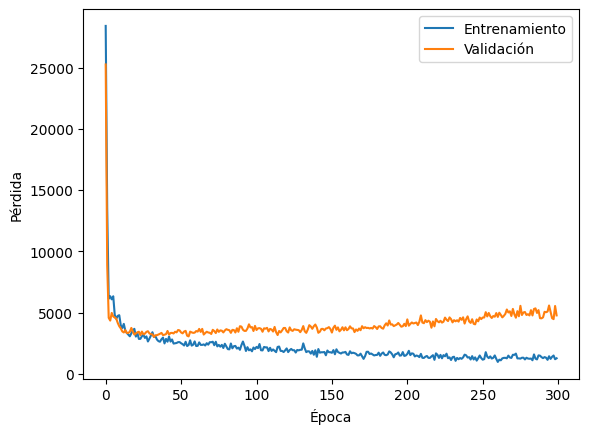

In [67]:
class red2(nn.Module):
  def __init__(self, d_ent):
    # Se inicia el super constructor
    super(red2, self).__init__()
    self.cod = nn.ModuleList([nn.Linear(d_ent, 10), nn.Linear(10,20), nn.Linear(20,d_ent), nn.Linear(d_ent, 5)])
    # Normalizador
    self.norm = nn.BatchNorm1d(20)
    self.salida = nn.Linear(5,1)
    # instanciamos Dropout
    self.dropout = nn.Dropout(.25)
  

  # Definimos el forward
  def forward(self, x):
    for i, c in enumerate(self.cod):
      if i == 1:
        x = nn.functional.sigmoid(c(x))
        x = self.norm(x)
      else:
        x = nn.functional.relu(c(x))
    return self.salida(x)

# Entrenamos el modelo
modelo = red2(X_ent.shape[-1])
modelo.to(disp)

#Perdida
ecm = nn.MSELoss()
#Optimizador
opt = AdamW(modelo.parameters(), lr=1e-2)
#Entrenamiento
hist = entrena(modelo, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=300)

plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

### Red 3

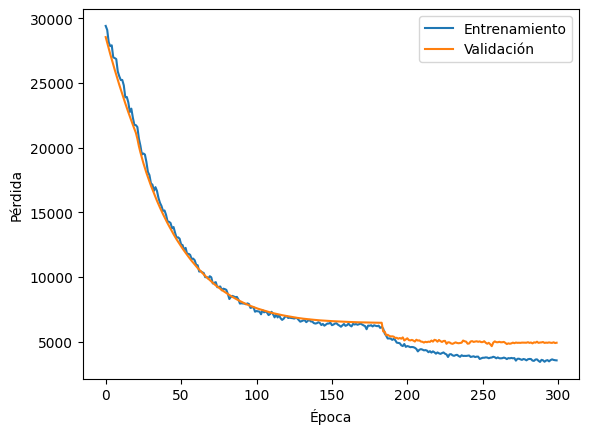

In [68]:
class red3(nn.Module):
  def __init__(self, d_ent):
    # Se inicia el super constructor
    super(red3, self).__init__()
    self.cod = nn.ModuleList([nn.Linear(d_ent, 10), nn.Linear(10,156), nn.Linear(156,40), nn.Linear(40, 5)])
    self.salida = nn.Linear(5,1)
    # instanciamos Dropout
    self.dropout = nn.Dropout(.5)
  

  # Definimos el forward
  def forward(self, x):
    for c in self.cod:
      x = nn.functional.sigmoid(c(x))
    return self.salida(x)

# Entrenamos el modelo
modelo = red3(X_ent.shape[-1])
modelo.to(disp)

#Perdida
ecm = nn.MSELoss()
#Optimizador
opt = AdamW(modelo.parameters(), lr=1e-2)
#Entrenamiento
hist = entrena(modelo, ecm, nn.functional.mse_loss, opt, entdl, valdl, n_epocas=300)

plt.plot(hist['perdida_ent'] / len(entdl), label='Entrenamiento')
plt.plot(hist['perdida_val'] / len(valdl), label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()